<a href="https://colab.research.google.com/github/cbandrowski/CSC467_Research_Demo/blob/main/U_Net_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Oxford  Dog



In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.JRIVGG_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.JRIVGG_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [4]:
!pip install tensorflow tensorflow-datasets --quiet

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


Loading Data set into TensorFLow Dataset for Training

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'oxford_iiit_pet:4.0.0',
    split=['train[:50]', 'train[50:55]'],# first 50 imgages for training next 5 for testing
    with_info=True
)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.2OJKJQ_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.2OJKJQ_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [6]:
IMG_SIZE = 128

def preprocess(example):
    image = tf.image.resize(example['image'], (128, 128)) / 255.0
    mask = tf.image.resize(example['segmentation_mask'], (128, 128), method='nearest')

    # Ensure correct class handling: 1 (pet) + 2 (outline) → 1, 0 (background) → 0
    mask = tf.cast(mask, tf.uint8)
    mask = tf.where(tf.math.logical_or(mask == 1, mask == 2), 1.0, 0.0)

    return image, mask






In [7]:
BATCH_SIZE = 16
train_ds = ds_train.map(preprocess).cache().shuffle(100).batch(16).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(16).prefetch(tf.data.AUTOTUNE)






In [8]:
from tensorflow.keras import layers, Model

def unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = tf.keras.Input(input_shape)

    # Encoder (Extracts features while reducing spatial dimensions)
    #Block 1: Two 3x3 conv layers with 64 filters + max pooling
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1) #Downsample 1/2

    #Block 2: Two 3x3 conv layers with 128 filters + max pooling
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)#Downsample 1/2

    #Block 3: Two 3x3 conv layers with 256 filters + max pooling
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)#Downsmaple to deepest level

    # Bottleneck (High-level features at the deepest resolution)
    #Deepest part of U-Net two conv layers with 512 filters
    b = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    b = layers.Conv2D(512, 3, activation='relu', padding='same')(b)

    # Decoder(Reconstructs the image segmentation, step-by-step,
    # using skip connections to maintain detail.)
    # Block 1: Upsample + concat with c3 (skip connection), then convs
    u1 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(b) # Upsample 2x
    u1 = layers.Concatenate()([u1, c3])# Skip connection
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(c4)

    # Block 2: Upsample + concat with c2 (skip), then convs
    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c4)
    u2 = layers.Concatenate()([u2, c2])# Skip connection
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(c5)

     # Block 3: Upsample + concat with c1 (skip), then convs
    u3 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c5)
    u3 = layers.Concatenate()([u3, c1])#Final Skip connection
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(c6)

    #Output Layer
    # 1x1 conv to reduce depth to 1 (binary mask), sigmoid for [0,1] output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c6)

    return Model(inputs, outputs)

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │    131,200 │ conv2d_9[0][0]  

 Total params: 7,697,345 (29.36 MB)

 Trainable params: 7,697,345 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(train_ds, validation_data=test_ds, epochs=1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 71s 14s/step - accuracy: 0.5002 - loss: 0.6547 - val_accuracy: 0.8773 - val_loss: 0.4468


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted min: 0.52102315 max: 0.9475602


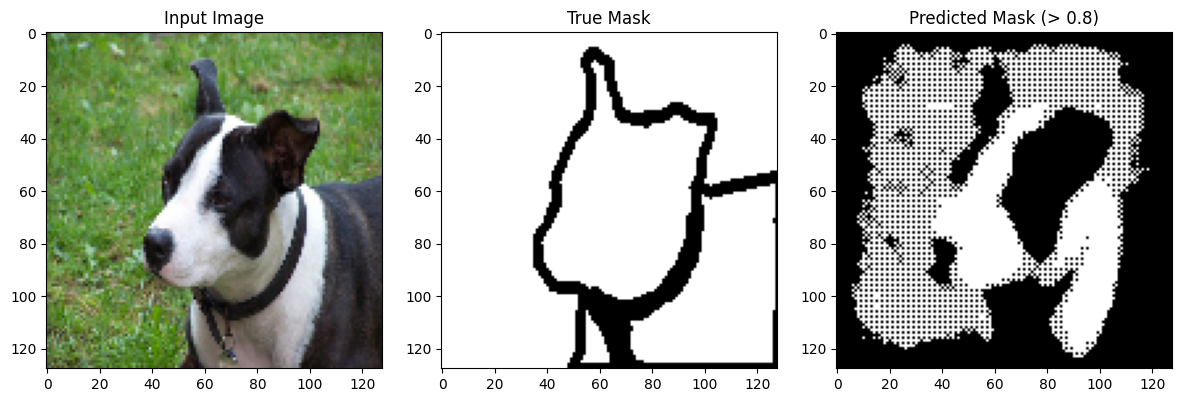

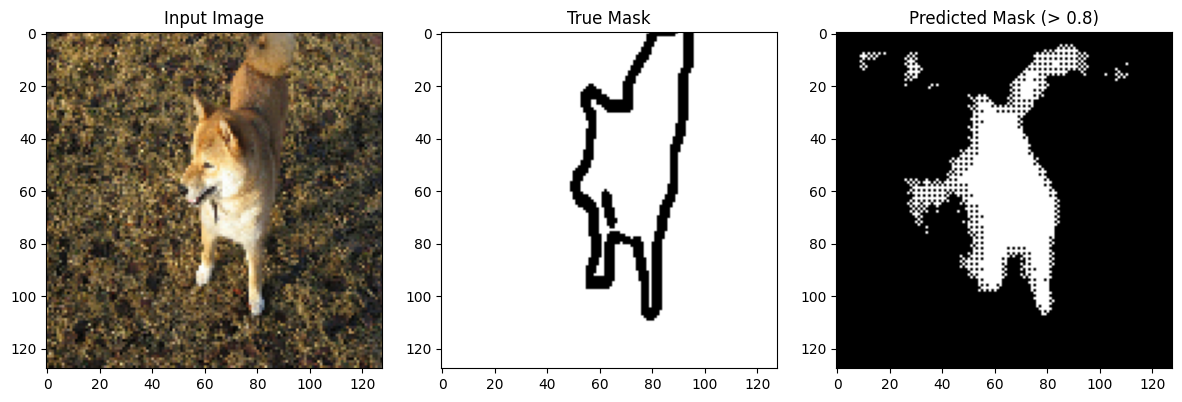

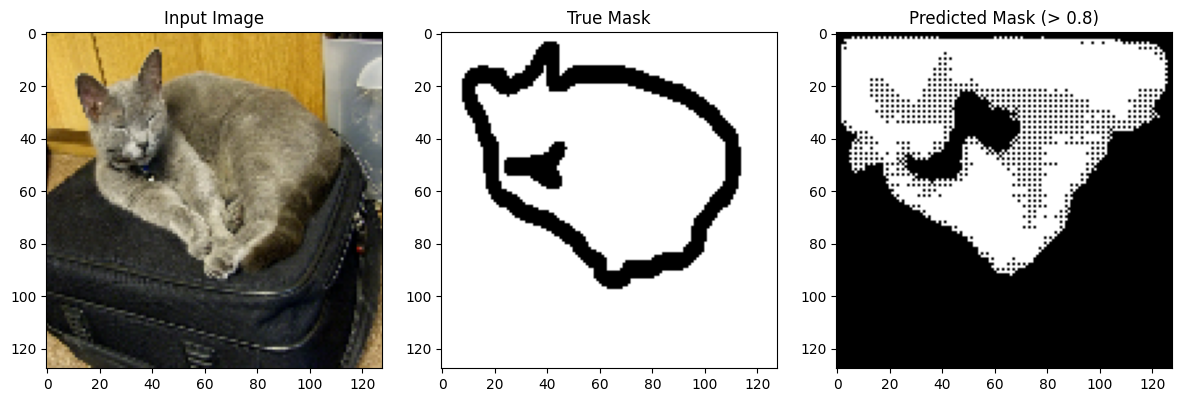

In [16]:
for images, masks in test_ds.take(1):
    preds = model.predict(images)

    print("Predicted min:", preds.min(), "max:", preds.max())  # Diagnostic

    threshold = 0.8  # Adjust if needed
    preds_binary = (preds > threshold).astype(np.uint8)

    for i in range(3):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(images[i].numpy())
        plt.title("Input Image")

        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].numpy().squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("True Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(preds_binary[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f"Predicted Mask (> {threshold})")

        plt.tight_layout()
        plt.show()



